In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np

# Load the combined narrative data
data_dir = '/content/drive/MyDrive/Colab Notebooks/Berkeley/266/FinalProject/Data/'
original_data = os.path.join(data_dir, 'ROCStories__spring2016 - ROCStories_spring2016.csv')

original_df = pd.read_csv(original_data)
batch_size = 5
original_df = original_df.iloc[batch_size:].head(40000)

mistral_df = pd.read_csv(os.path.join(data_dir, 'generated_narratives_mistral.csv'))
llama_df = pd.read_csv(os.path.join(data_dir, 'generated_narratives_llama.csv'))

# Fix Nan to ""
original_df = original_df.fillna("")
mistral_df = mistral_df.fillna("")
llama_df = llama_df.fillna("")

display(original_df.head())
display(mistral_df.head())
display(llama_df.head())

print(original_df.shape)
print(mistral_df.shape)
print(llama_df.shape)

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
5,5d5e7aeb-332f-4c8b-a3c3-44585501e493,Foolish Frank,Frank had been drinking beer.,"He got a call from his girlfriend, asking wher...",Frank suddenly realized he had a date that night.,"Since Frank was already a bit drunk, he could ...",Frank spent the rest of the night drinking mor...
6,bdceebb0-c6e8-417f-b6ae-741a0a71fcd3,Shark Adventure,Dave was in the Bahamas on vacation.,He decided to go snorkeling on his second day.,"While snorkeling, he saw a cave up ahead.","He went into the cave, and he was terrified wh...","Dave swam away as fast as he could, but the sh..."
7,a4a9aaca-d3d4-46b4-807c-ef75aea68c56,Too sunny for Sunny,Sunny enjoyed going to the beach.,"As she stepped out of her car, she realized sh...",It was quite sunny and she forgot her sunglasses.,Sunny got back into her car and heading toward...,Sunny found some sunglasses and headed back to...
8,8ddc9d26-d253-4eb3-b621-9a4e6d9c57e0,The Merry Widow,Sally was happy when her widowed mom found a n...,She discovered her siblings didn't feel the same.,Sally flew to visit her mom and her mom's new ...,"Although her mom was obviously in love, he was...",Sally went home and wondered about her parents...
9,80ff5d8f-bcb1-437b-9da1-71c52997def2,Golf Cheat,Dan hit his golf ball and watched it go.,The ball bounced on the grass and into the san...,Dan pretended that his ball actually landed on...,His friends were not paying attention so they ...,Dan snuck a ball on the green and made his put...


,sentence1,sentence2,sentence3,sentence4,sentence5
0,Frank had been drinking beer.,"He got a call from his girlfriend, asking wher...",Frank suddenly realized he had a date that night.,"Since Frank was already a bit drunk, he could ...",Frank called an Uber and was able to make it t...
1,Dave was in the Bahamas on vacation.,He decided to go snorkeling on his second day.,"While snorkeling, he saw a cave up ahead.","He went into the cave, and he was terrified wh...","Dave quickly swam back to the surface, scared ..."
2,Sunny enjoyed going to the beach.,"As she stepped out of her car, she realized sh...",It was quite sunny and she forgot her sunglasses.,Sunny got back into her car and heading toward...,Sunny bought a new pair of sunglasses at the m...
3,Sally was happy when her widowed mom found a n...,She discovered her siblings didn't feel the same.,Sally flew to visit her mom and her mom's new ...,"Although her mom was obviously in love, he was...","Although Sally struggled at first, she eventua..."
4,Dan hit his golf ball and watched it go.,The ball bounced on the grass and into the san...,Dan pretended that his ball actually landed on...,His friends were not paying attention so they ...,Dan's friends eventually noticed that his ball...


,sentence1,sentence2,sentence3,sentence4,sentence5
0,Frank had been drinking beer.,"He got a call from his girlfriend, asking wher...",Frank suddenly realized he had a date that night.,"Since Frank was already a bit drunk, he could ...","He called a taxi to pick him up, but it took a..."
1,Dave was in the Bahamas on vacation.,He decided to go snorkeling on his second day.,"While snorkeling, he saw a cave up ahead.","He went into the cave, and he was terrified wh...",He swam back to the surface and quickly paddle...
2,Sunny enjoyed going to the beach.,"As she stepped out of her car, she realized sh...",It was quite sunny and she forgot her sunglasses.,Sunny got back into her car and heading toward...,She went to the mall to buy a new pair of sung...
3,Sally was happy when her widowed mom found a n...,She discovered her siblings didn't feel the same.,Sally flew to visit her mom and her mom's new ...,"Although her mom was obviously in love, he was...","Her mom's new husband seemed kind, but Sally n..."
4,Dan hit his golf ball and watched it go.,The ball bounced on the grass and into the san...,Dan pretended that his ball actually landed on...,His friends were not paying attention so they ...,"His friends were impressed by his fake shot, b..."


(40000, 7)
(40000, 5)
(40000, 5)


In [3]:
!pip install sentence_transformers -q

In [4]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [7]:
import torch
print("GPU Available:", torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize sentence transformer model and rouge scorer once
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)  # Lightweight model for embedding similarity

def evaluate_generated_sentences(original_df, generated_df):
    cosine_similarities = []

    # Evaluate each pair of sentences
    for i in range(len(original_df)):
        reference = original_df.iloc[i]['sentence5']  # Original fifth sentence
        candidate = generated_df.iloc[i]['sentence5']  # Generated fifth sentence

        # Cosine Similarity
        reference_embedding = model.encode(reference, convert_to_tensor=True)
        candidate_embedding = model.encode(candidate, convert_to_tensor=True)
        cosine_similarity_score = util.cos_sim(reference_embedding, candidate_embedding).item()
        cosine_similarities.append(cosine_similarity_score)

    # Combine results into a DataFrame
    evaluation_df = pd.DataFrame({
        'Cosine Similarity': cosine_similarities
    })

    # Display summary statistics
    print("Evaluation Summary:")
    display(evaluation_df.describe())

    return evaluation_df


GPU Available: True


In [8]:
# Evaluate mistral_df
mistral_evaluation = evaluate_generated_sentences(original_df, mistral_df)

# Evaluate llama_df
llama_evaluation = evaluate_generated_sentences(original_df, llama_df)

Evaluation Summary:


,Cosine Similarity
count,40000.000000
mean,0.437778
std,0.189451
min,-0.131355
25%,0.296796
50%,0.444317
75%,0.580617
max,1.000000


Evaluation Summary:


,Cosine Similarity
count,40000.000000
mean,0.428432
std,0.175660
min,-0.119689
25%,0.300841
50%,0.428242
75%,0.555743
max,0.950530


In [9]:
print("Mistral Evaluation Summary:")
display(mistral_evaluation)

print("\nLlama Evaluation Summary:")
display(llama_evaluation)

Mistral Evaluation Summary:


,Cosine Similarity
0,0.484238
1,0.667940
2,0.602152
3,0.555086
4,0.647592
...,...
39995,0.372252
39996,0.284690
39997,0.198447
39998,0.448447



Llama Evaluation Summary:


,Cosine Similarity
0,0.230200
1,0.702011
2,0.463467
3,0.671579
4,0.482724
...,...
39995,0.535904
39996,0.430697
39997,0.329755
39998,0.439207


In [10]:

labels = []
for i in range(len(mistral_evaluation)):
    if mistral_evaluation.iloc[i]['Cosine Similarity'] > llama_evaluation.iloc[i]['Cosine Similarity']:
        labels.append(0)
    else:
        labels.append(1)

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 

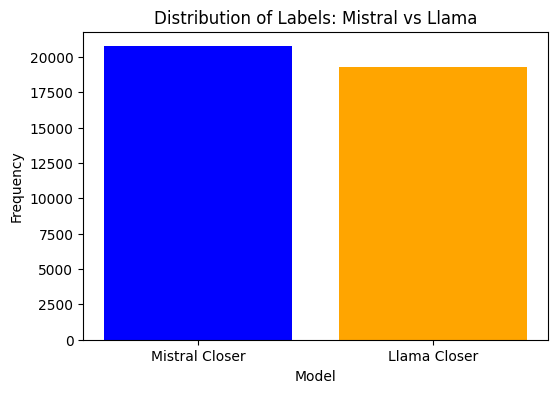

In [11]:
print(labels)
import matplotlib.pyplot as plt

# Assuming labels is defined
# Plotting label distribution
plt.figure(figsize=(6, 4))
plt.bar([0, 1], [labels.count(0), labels.count(1)], color=['blue', 'orange'])
plt.xticks([0, 1], ['Mistral Closer', 'Llama Closer'])
plt.xlabel('Model')
plt.ylabel('Frequency')
plt.title('Distribution of Labels: Mistral vs Llama')
plt.show()

In [12]:
# Ensure the DataFrames are aligned
original_df = original_df.reset_index(drop=True)
mistral_df = mistral_df.reset_index(drop=True)
llama_df = llama_df.reset_index(drop=True)

# Create the combined DataFrame
combined_df = pd.DataFrame({
    'sentence1': original_df['sentence1'],
    'sentence2': original_df['sentence2'],
    'sentence3': original_df['sentence3'],
    'sentence4': original_df['sentence4'],
    'sentence5': original_df['sentence5'],
    'mistral_sentence5': mistral_df['sentence5'],
    'llama_sentence5': llama_df['sentence5'],
    'label': labels
})

# Display the first few rows
display(combined_df.head())

# Save the DataFrame to a CSV file
output_csv_path = os.path.join(data_dir, 'sentences_with_labels.csv')
combined_df.to_csv(output_csv_path, index=False)

print(f"Combined DataFrame saved to {output_csv_path}")

,sentence1,sentence2,sentence3,sentence4,sentence5,mistral_sentence5,llama_sentence5,label
0,Frank had been drinking beer.,"He got a call from his girlfriend, asking wher...",Frank suddenly realized he had a date that night.,"Since Frank was already a bit drunk, he could ...",Frank spent the rest of the night drinking mor...,Frank called an Uber and was able to make it t...,"He called a taxi to pick him up, but it took a...",0
1,Dave was in the Bahamas on vacation.,He decided to go snorkeling on his second day.,"While snorkeling, he saw a cave up ahead.","He went into the cave, and he was terrified wh...","Dave swam away as fast as he could, but the sh...","Dave quickly swam back to the surface, scared ...",He swam back to the surface and quickly paddle...,1
2,Sunny enjoyed going to the beach.,"As she stepped out of her car, she realized sh...",It was quite sunny and she forgot her sunglasses.,Sunny got back into her car and heading toward...,Sunny found some sunglasses and headed back to...,Sunny bought a new pair of sunglasses at the m...,She went to the mall to buy a new pair of sung...,0
3,Sally was happy when her widowed mom found a n...,She discovered her siblings didn't feel the same.,Sally flew to visit her mom and her mom's new ...,"Although her mom was obviously in love, he was...",Sally went home and wondered about her parents...,"Although Sally struggled at first, she eventua...","Her mom's new husband seemed kind, but Sally n...",1
4,Dan hit his golf ball and watched it go.,The ball bounced on the grass and into the san...,Dan pretended that his ball actually landed on...,His friends were not paying attention so they ...,Dan snuck a ball on the green and made his put...,Dan's friends eventually noticed that his ball...,"His friends were impressed by his fake shot, b...",0


Combined DataFrame saved to /content/drive/MyDrive/Colab Notebooks/Berkeley/266/FinalProject/Data/sentences_with_labels.csv


In [ ]:
# Shutdown google colab runtime
from google.colab import runtime
runtime.unassign()